# Installations/Préparations

## install

In [4]:
!pip install importlib-metadata==4.13.0
!pip install setuptools==65.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.1.0
    Uninstalling importlib-metadata-6.1.0:
      Successfully uninstalled importlib-metadata-6.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.1
    Uninstalling setuptools-67.6.1:
      Successfully uninstalled setuptools-67.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.1 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.


In [5]:
!pip install git+https://github.com/osigaud/bbrl_gym

!pip install git+https://github.com/osigaud/bbrl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/osigaud/bbrl_gym to /tmp/pip-req-build-qgtlw6os
  Running command git clone --filter=blob:none --quiet https://github.com/osigaud/bbrl_gym /tmp/pip-req-build-qgtlw6os
  Resolved https://github.com/osigaud/bbrl_gym to commit 5557075ecd7d4171ac0c21be3c69a94bcae655a9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 42.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.3 MB/s eta 0:00:00
  Created wheel for bbrl-gym: filename=bbrl_gym-1.2.5-py3-none-any.whl size=17602 sha256=575bcc05dda135741db

In [6]:
!pip install omegaconf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144573 sha256=2506f6404cf8d4d310315720e619751327135b52d3b9a06de485bc5d569d5f60
  Stored in directory: /root/.cache/pip/wheels/23/cf/80/f3efa822e6ab23277902ee9165fe772eeb1dfb8014f359020a
Successfully built antlr4-python3-runtime


## import

In [7]:
from bbrl.workspace import Workspace
from bbrl import get_class, get_arguments, instantiate_class

import bbrl_gym
import gym

from bbrl.agents.agent import Agent
from bbrl.agents import Agents, TemporalAgent
from bbrl.agents.gymb import NoAutoResetGymAgent

from bbrl.utils.replay_buffer import ReplayBuffer
from bbrl.utils.chrono import Chrono

from bbrl.visu.visu_policies import plot_policy
from bbrl.visu.visu_critics import plot_critic
from bbrl.visu.common import final_show

from omegaconf import OmegaConf
from omegaconf import DictConfig

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import time
import matplotlib
import os
import functools
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import copy

# Agents

In [8]:
class MazeMDPContinuousWrapper(gym.Wrapper):
    """
    Specific wrapper to turn the Tabular MazeMDP into a continuous state version
    """

    def __init__(self, env):
        super(MazeMDPContinuousWrapper, self).__init__(env)
        # Building a new continuous observation space from the coordinates of each state
        high = np.array(
            [
                env.coord_x.max() + 1,
                env.coord_y.max() + 1,
            ],
            dtype=np.float32,
        )
        low = np.array(
            [
                env.coord_x.min(),
                env.coord_y.min(),
            ],
            dtype=np.float32,
        )
        self.observation_space = gym.spaces.Box(low, high)

    def is_continuous_state(self):
        # By contrast with the wrapped environment where the state space is discrete
        return True

    def reset(self):
        obs = self.env.reset()
        x = self.env.coord_x[obs]
        y = self.env.coord_y[obs]
        xc = x + random.random()
        yc = y + random.random()
        continuous_obs = [xc, yc]
        return continuous_obs

    def step(self, action):
        # Turn the discrete state into a pair of continuous coordinates
        # Take the coordinates of the state and add a random number to x and y to
        # sample anywhere in the [1, 1] cell...
        next_state, reward, done, info = self.env.step(action)
        x = self.env.coord_x[next_state]
        y = self.env.coord_y[next_state]
        xc = x + random.random()
        yc = y + random.random()
        next_continuous = [xc, yc]
        return next_continuous, reward, done, info


class Logger:
    def __init__(self, cfg):
        self.logger = instantiate_class(cfg.logger)

    def add_log(self, log_string, loss, epoch):
        self.logger.add_scalar(log_string, loss.item(), epoch)

    # Log losses
    def log_losses(self, epoch, critic_loss, entropy_loss, actor_loss):
        self.add_log("critic_loss", critic_loss, epoch)
        self.add_log("entropy_loss", entropy_loss, epoch)
        self.add_log("actor_loss", actor_loss, epoch)

    def log_reward_losses(self, rewards, nb_steps):
        self.add_log("reward/mean", rewards.mean(), nb_steps)
        self.add_log("reward/max", rewards.max(), nb_steps)
        self.add_log("reward/min", rewards.min(), nb_steps)
        self.add_log("reward/median", rewards.median(), nb_steps)

def format_num(num, pos):
    # Pos is a required parameter, but it is not used
    magnitude = 0
    labels = ["", "K", "M", "G"]
    while abs(num) >= 1e3:
        magnitude += 1
        num /= 1e3

    return f"{num:.1f}{labels[magnitude]}"

class Plotter:
    def __init__(self, steps_filename, rewards_filename):
        self.steps_filename = steps_filename
        self.rewards_filename = rewards_filename

    def plot_reward(
        self,
        algo_name,
        env_name,
        mode="mean",
        prefix="",
        suffix=".pdf",
        save_fig=True,
        save_dir="./plots/",
    ):
        _, ax = plt.subplots(figsize=(9, 6))
        formatter = FuncFormatter(format_num)

        colors = ["#09b542", "#008fd5", "#fc4f30", "#e5ae38", "#e5ae38", "#810f7c"]
        color = colors[0]

        loader = RewardLoader(self.steps_filename, self.rewards_filename)
        steps, rewards = loader.load()
        print(steps, rewards)
        # steps, rewards = equalize_lengths(steps, rewards)

        if mode == "best":
            best = rewards.sum(axis=1).argmax()
            mean = rewards[best]
        elif mode == "max":
            mean = np.max(rewards, axis=0)
        else:
            std = rewards.std(axis=0)
            mean = rewards.mean(axis=0)
            ax.fill_between(steps, mean + std, mean - std, alpha=0.1, color=color)
        ax.plot(steps, mean, lw=2, label=f"{algo_name}", color=color)
        ax.xaxis.set_major_formatter(formatter)
        plt.legend()

        save_dir += f"{env_name}/"

        clean_env_name = env_name.split("-")[0]
        figure_name = f"{prefix}{clean_env_name.lower()}_{mode}"
        title = f"{clean_env_name} ({mode})"
        if suffix:
            figure_name += f"{suffix}"
        final_show(save_fig, True, save_dir, figure_name, "timesteps", "rewards", title)

    def plot_histograms(
        self,
        rewards,
        env_name,
        suffix="",
        save_dir="./plots/",
        plot=True,
        save_fig=True,
    ):
        plt.figure(figsize=(9, 6))

        colors = ["#09b542", "#008fd5", "#fc4f30", "#e5ae38", "#e5ae38", "#810f7c"]
        # colors = ["#fc4f30", "#008fd5", "#e5ae38"]

        n_bars = len(rewards)
        x = np.arange(len(list(rewards.values())[0]))
        width = 0.75 / n_bars

        for i, reward in enumerate(rewards.values()):
            plt.bar(x + width * i, np.sort(reward)[::-1], width=width, color=colors[i])

        plt.legend(labels=rewards.keys())
        plt.xticks([], [])

        save_dir += f"{env_name}/"

        clean_env_name = env_name.split("-")[0]
        title = clean_env_name
        figure_name = f"{clean_env_name.lower()}-histograms"

        if suffix:
            title += f" ({suffix})"
            figure_name += f"{suffix}"

        final_show(save_fig, plot, save_dir, figure_name, "", "rewards", title)

class RewardLogger:
    def __init__(self, steps_filename, rewards_filename):
        self.steps_filename = steps_filename
        self.rewards_filename = rewards_filename
        self.episode = 0
        self.all_rewards = []
        self.all_rewards.append([])
        self.all_steps = []

    def add(self, nb_steps, reward):
        if self.episode == 0:
            self.all_steps.append(nb_steps)
        self.all_rewards[self.episode].append(reward.item())

    def new_episode(self):
        self.episode += 1
        self.all_rewards.append([])

    def save(self):
        # print("reward loader save:", self.all_steps,  self.all_rewards)
        with open(self.steps_filename, "ab") as f:
            np.save(f, self.all_steps)
        with open(self.rewards_filename, "ab") as f:
            np.save(f, self.all_rewards)

class RewardLoader:
    def __init__(self, steps_filename, rewards_filename):
        self.steps_filename = steps_filename
        self.rewards_filename = rewards_filename

    def load(self):
        with open(self.steps_filename, "rb") as f:
            steps = np.load(f, allow_pickle=True)
        with open(self.rewards_filename, "rb") as f:
            rewards = np.load(f, allow_pickle=True)
        return steps, rewards

In [24]:
def build_mlp(sizes, activation, output_activation=nn.Identity()):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act]
    return nn.Sequential(*layers)


class DiscreteQAgent(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.model = build_mlp(
            [state_dim] + list(hidden_layers) + [action_dim], activation=nn.ReLU()
        )

    def forward(self, t, choose_action=True, **kwargs):
        obs = self.get(("env/env_obs", t))
        q_values = self.model(obs).squeeze(-1)
        self.set(("q_values", t), q_values)
        
        if choose_action:
            action = q_values.argmax(1)
            self.set(("action", t), action)


class ContinuousQAgent(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.is_q_function = True
        self.model = build_mlp(
            [state_dim + action_dim] + list(hidden_layers) + [1], activation=nn.ReLU()
        )

    def forward(self, t, detach_actions=False):
        obs = self.get(("env/env_obs", t))
        action = self.get(("action", t))
        if detach_actions:
            action = action.detach()
        osb_act = torch.cat((obs, action), dim=1)
        q_value = self.model(osb_act)
        self.set(("q_value", t), q_value)

    def predict_value(self, obs, action):
        obs_act = torch.cat((obs, action), dim=0)
        q_value = self.model(obs_act)
        return q_value


def make_gym_env(env_name, env_kwargs):
    env = MazeMDPContinuousWrapper(
        gym.make(env_name, kwargs=env_kwargs)
    )
    return env


class EGreedyActionSelector(Agent):
    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, t, **kwargs):
        q_values = self.get(("q_values", t))
        nb_actions = q_values.size()[1]
        size = q_values.size()[0]
        is_random = torch.rand(size).lt(self.epsilon).float()
        random_action = torch.randint(low=0, high=nb_actions, size=(size,))
        max_action = q_values.max(1)[1]
        action = is_random * random_action + (1 - is_random) * max_action
        action = action.long()
        self.set(("action", t), action)

# TEST

## PARAMS

In [20]:
params={
  "save_best": False,
  "plot_agents": True,
  
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./dqn_logs/",
    "cache_size": 10000,
    "every_n_seconds": 5,
    "verbose": False,    
  },

  "algorithm":{
    "seed": 3,
    "nb_seeds": 1,
    "buffer_size": 1e6,
    "epsilon": 0.1,                 # valeur pour epsilon-greedy
    "n_updates": 50,                # nb d'update par Replay Buffer
    "n_steps": 64,                  # nb max de step par épisode ?
    "n_envs": 1,                   # nb d'environnement en simultané (nb d'épisodes ?)
    "nb_episodes": 50,              # nb d'épisodes
    "nb_evals": 10,                 # nb d'évaluation après train
    "eval_interval": 50,            # intervalle (steps) entre évaluations
    "discount_factor": 0.99,        # delta
    "target_critic_update": 100,    # intervalle (steps) entre chaque maj de Q_target
    "batch_size": 100,              # taille du batch Replay Buffer
    "learning_starts": 5,           # ???

    "max_grad_norm": 0.5,
    "architecture":{"hidden_size": [128, 128]},
  },

  "gym_env":{
    "classname": "__main__.make_gym_env",
    "env_name": "MazeMDP-v0",
    "env_kwargs": {"width": 5, "height": 5, "ratio": 0.2},
  },

  "optimizer":{
    "classname": "torch.optim.Adam",
    "lr": 2e-3,
  }
}

config = OmegaConf.create(params)

## SET-UP

In [30]:
def get_env_agents(cfg):
    train_env_agent = NoAutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        cfg.algorithm.n_envs,
        cfg.algorithm.seed,
    )
    eval_env_agent = NoAutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        cfg.algorithm.nb_evals,
        cfg.algorithm.seed,
    )
    return train_env_agent, eval_env_agent


def create_dqn_agent(cfg, train_env_agent, eval_env_agent):
    obs_size, act_size = train_env_agent.get_obs_and_actions_sizes()

    critic = DiscreteQAgent(obs_size, cfg.algorithm.architecture.hidden_size, act_size)
    explorer = EGreedyActionSelector(cfg.algorithm.epsilon)
    target_critic = copy.deepcopy(critic)

    q_agent = TemporalAgent(critic)
    target_q_agent = TemporalAgent(target_critic)
    
    tr_agent = Agents(train_env_agent, critic, explorer)
    ev_agent = Agents(eval_env_agent, critic)
    # Get an agent that is executed on a complete workspace
    train_agent = TemporalAgent(tr_agent)
    eval_agent = TemporalAgent(ev_agent)
    
    train_agent.seed(cfg.algorithm.seed)
    return train_agent, eval_agent, q_agent, target_q_agent


# Configure the optimizer
def setup_optimizers(cfg, q_agent):
    optimizer_args = get_arguments(cfg.optimizer)
    parameters = q_agent.parameters()
    optimizer = get_class(cfg.optimizer)(parameters, **optimizer_args)
    return optimizer


def compute_critic_loss(cfg, reward, must_bootstrap, q_values, target_q_values, action):
    # Compute temporal difference
    max_q = target_q_values.max(-1)[0].detach()

    target = (
        reward[:-1].squeeze()
        + cfg.algorithm.discount_factor * max_q * must_bootstrap.int()
    )

    act = action[0].unsqueeze(-1)
    qvals = torch.gather(q_values, dim=1, index=act).squeeze()

    mse = nn.MSELoss()
    critic_loss = mse(target, qvals)
    return critic_loss

## RUN

In [29]:
def run_dqn(cfg, reward_logger):
    print("0")
    # 1)  Build the  logger
    logger = Logger(cfg)
    best_reward = -10e9
    print("1")

    # 2) Create the environment agent
    train_env_agent, eval_env_agent = get_env_agents(cfg)
    print("2")

    # 3) Create the DQN-like Agent
    train_agent, eval_agent, q_agent, target_q_agent = create_dqn_agent(cfg, train_env_agent, eval_env_agent)
    print("3.1")

    # Used for training
    train_workspace = Workspace()
    print("3.2")

    # 4) Create the Replay Buffer Agent
    rb = ReplayBuffer(max_size=cfg.algorithm.buffer_size)
    print("4")

    # 5) Create the HER Agent
    # her = HERAgent(pass)
    # print("A")

    # 6) Configure the optimizer
    optimizer = setup_optimizers(cfg, q_agent)
    nb_steps = 0
    tmp_steps = 0
    tmp_steps2 = 0
    print("6")

    # 7) Training
    # Train des épisodes        
    train_agent(train_workspace, t=0, stop_variable="env/done", stochastic=True)
    print("7.0.1")

    transition_workspace = train_workspace.get_transitions()
    print("7.0.2")

    # comptage du nb de step de l'épisode
    action = transition_workspace["action"]
    nb_steps += action[0].shape[0]
    print("7.0.3")

    # ajout des transitions au RB
    rb.put(transition_workspace)
    print("7.0.4")

    # 7.1) Loop Replay Buffer
    for _ in range(cfg.algorithm.n_updates):
        # mélange et création du RB_W
        rb_workspace = rb.get_shuffled(cfg.algorithm.batch_size)

        # The q agent needs to be executed on the rb_workspace workspace (gradients are removed in workspace).
        q_agent(rb_workspace, t=0, n_steps=2, choose_action=False)

        q_values, done, truncated, reward, action = rb_workspace[
            "q_values", "env/done", "env/truncated", "env/reward", "action"
        ]

        with torch.no_grad():
            target_q_agent(rb_workspace, t=0, n_steps=2, stochastic=True)

        target_q_values = rb_workspace["q_values"]
        # assert torch.equal(q_values, target_q_values), "values differ"

        # Determines whether values of the critic should be propagated
        # True if the episode reached a time limit or if the task was not done
        # See https://colab.research.google.com/drive/1erLbRKvdkdDy0Zn1X_JhC01s1QAt4BBj?usp=sharing
        must_bootstrap = torch.logical_or(~done[1], truncated[1])

        if rb.size() > cfg.algorithm.learning_starts:
            # Compute critic loss
            critic_loss = compute_critic_loss(
                cfg, reward, must_bootstrap, q_values[0], target_q_values[1], action
            )

            # Store the loss for tensorboard display
            logger.add_log("critic_loss", critic_loss, nb_steps)

            optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(
                q_agent.parameters(), cfg.algorithm.max_grad_norm
            )
            optimizer.step()
    print("7.1")

    # 7.2) Maj du Q_target (sous conditions)
    if nb_steps - tmp_steps2 > cfg.algorithm.target_critic_update:
        tmp_steps2 = nb_steps
        target_q_agent.agent = copy.deepcopy(q_agent.agent)
        print("7.2")

    # 7.3) Évaluation régulère
    if nb_steps - tmp_steps > cfg.algorithm.eval_interval:
        tmp_steps = nb_steps
        eval_workspace = Workspace()  # Used for evaluation
        eval_agent(
            eval_workspace, t=0, stop_variable="env/done", choose_action=True
        )
        rewards = eval_workspace["env/cumulated_reward"][-1]
        mean = rewards.mean()
        logger.add_log("reward", mean, nb_steps)
        reward_logger.add(nb_steps, mean)

        if cfg.save_best and mean > best_reward:
            best_reward = mean
            directory = "./dqn_critic/"
            if not os.path.exists(directory):
                os.makedirs(directory)
            filename = directory + "dqn_" + str(mean.item()) + ".agt"
            eval_agent.save_model(filename)

            if cfg.plot_agents:
                policy = eval_agent.agent.agents[1]
                plot_policy(
                    policy,
                    eval_env_agent,
                    "./dqn_plots/",
                    cfg.gym_env.env_name,
                    best_reward,
                    stochastic=False,
                )
                plot_critic(
                    policy,
                    eval_env_agent,
                    "./dqn_plots/",
                    cfg.gym_env.env_name,
                    best_reward,
                )
        print("7.3")

## MAIN

In [1]:
def main_loop(cfg):
    chrono = Chrono()
    logdir = "./plot/"

    if not os.path.exists(logdir):
        os.makedirs(logdir)
        
    reward_logger = RewardLogger(logdir + "dqn_her.steps", logdir + "dqn_her.rwd")

    for seed in range(cfg.algorithm.nb_seeds):
        cfg.algorithm.seed = seed
        torch.manual_seed(cfg.algorithm.seed)
        run_dqn(cfg, reward_logger)
        if seed < cfg.algorithm.nb_seeds - 1:
            reward_logger.new_episode()

    reward_logger.save()
    chrono.stop()
    plotter = Plotter(logdir + "dqn_her.steps", logdir + "dqn_her.rwd")
    plotter.plot_reward("dqn her", cfg.gym_env.env_name)

0
1
2
3.1
3.2
4
6
7.0.1
7.0.2
7.0.3
7.0.4
7.1
Time : 0s 678ms
[2500] [[0.]]


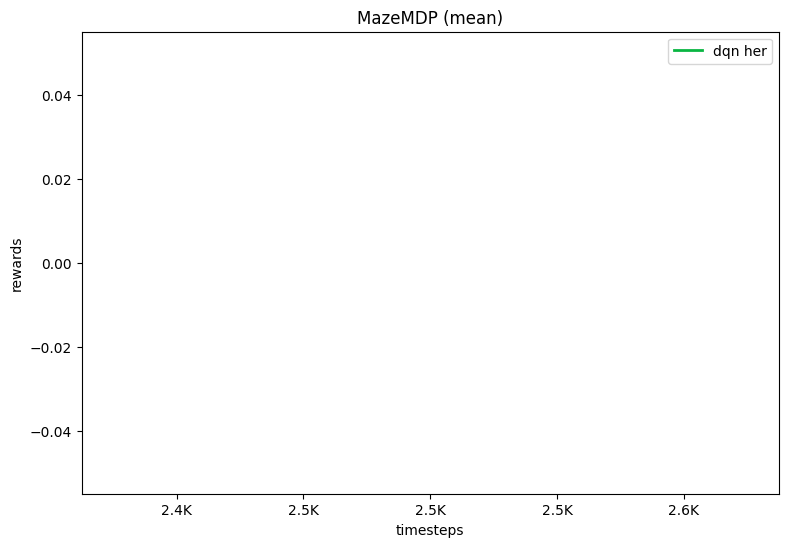

In [31]:
main_loop(config)